In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np
import cv2
import os
from tensorflow.keras import Input
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

In [2]:
sharpening_kernel = np.array([[0, -1, 0], 
                              [-1, 5, -1], 
                              [0, -1, 0]])

edge_detection_kernel = np.array([[-1, -1, -1], 
                                  [-1, 8, -1], 
                                  [-1, -1, -1]])

In [3]:
def preprocess_image(img):
    img_sharpened = cv2.filter2D(img, -1, sharpening_kernel)
    img_edge = cv2.filter2D(img, -1, edge_detection_kernel)
    return img_sharpened, img_edge

In [4]:
def load_and_preprocess_images(data_dir):
    images = []
    labels = []
    class_names = sorted(os.listdir(data_dir))
    
    for label in class_names:
        label_dir = os.path.join(data_dir, label)
        if not os.path.isdir(label_dir):
            continue
            
        for file in os.listdir(label_dir):
            if file.endswith('.PNG'):  # Ensure case sensitivity matches the file extensions
                img_path = os.path.join(label_dir, file)
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Warning: Unable to load image {img_path}")
                    continue
                
                img = cv2.resize(img, (64, 64))  # Resize to a uniform size
                img_sharpened, img_edge = preprocess_image(img)
                combined_img = np.concatenate((img_sharpened, img_edge), axis=-1)
                images.append(combined_img)
                labels.append(class_names.index(label))
    
    print(f"Total images loaded: {len(images)}")
    return np.array(images), np.array(labels), class_names

In [5]:
data_dir = 'Nail/Nail_Images/train'
X, y, class_names = load_and_preprocess_images(data_dir)

Total images loaded: 647


In [6]:
if len(X) == 0:
    raise ValueError("No images were loaded. Please check the directory and file paths.")

In [7]:
X = X / 255.0

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
model = Sequential([
    Input(shape=(64, 64, 6)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(class_names), activation='softmax')
])

In [10]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.1013 - loss: 2.8528 - val_accuracy: 0.0923 - val_loss: 2.7845
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.1369 - loss: 2.7000 - val_accuracy: 0.1538 - val_loss: 2.7367
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.2144 - loss: 2.5479 - val_accuracy: 0.1692 - val_loss: 2.7092
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.2972 - loss: 2.2592 - val_accuracy: 0.1846 - val_loss: 2.9207
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3698 - loss: 2.0154 - val_accuracy: 0.2385 - val_loss: 2.6659
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4969 - loss: 1.6596 - val_accuracy: 0.2308 - val_loss: 2.8003
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5853 - loss: 1.3940 - val_accuracy: 0.2538 - val_loss: 3.1290
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6402 - loss: 1.2558 - val_accuracy: 0.2154 - v

In [12]:
def predict_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (64, 64))
    img_sharpened, img_edge = preprocess_image(img)
    combined_img = np.concatenate((img_sharpened, img_edge), axis=-1)
    combined_img = combined_img / 255.0
    combined_img = np.expand_dims(combined_img, axis=0)
    
    predictions = model.predict(combined_img)
    predicted_label = np.argmax(predictions[0])
    return class_names[predicted_label]

In [13]:
model.save('nail_model.keras')

In [14]:
model1=load_model('nail_model.keras')

In [15]:
test_image_path = 'Nail/Nail_Images/train/bluish nail/8.PNG'
predicted_label = predict_image(test_image_path)
print(f'Predicted Label: {predicted_label}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predicted Label: bluish nail


In [16]:
y_val_pred_probs = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [17]:
conf_matrix = confusion_matrix(y_val, y_val_pred)

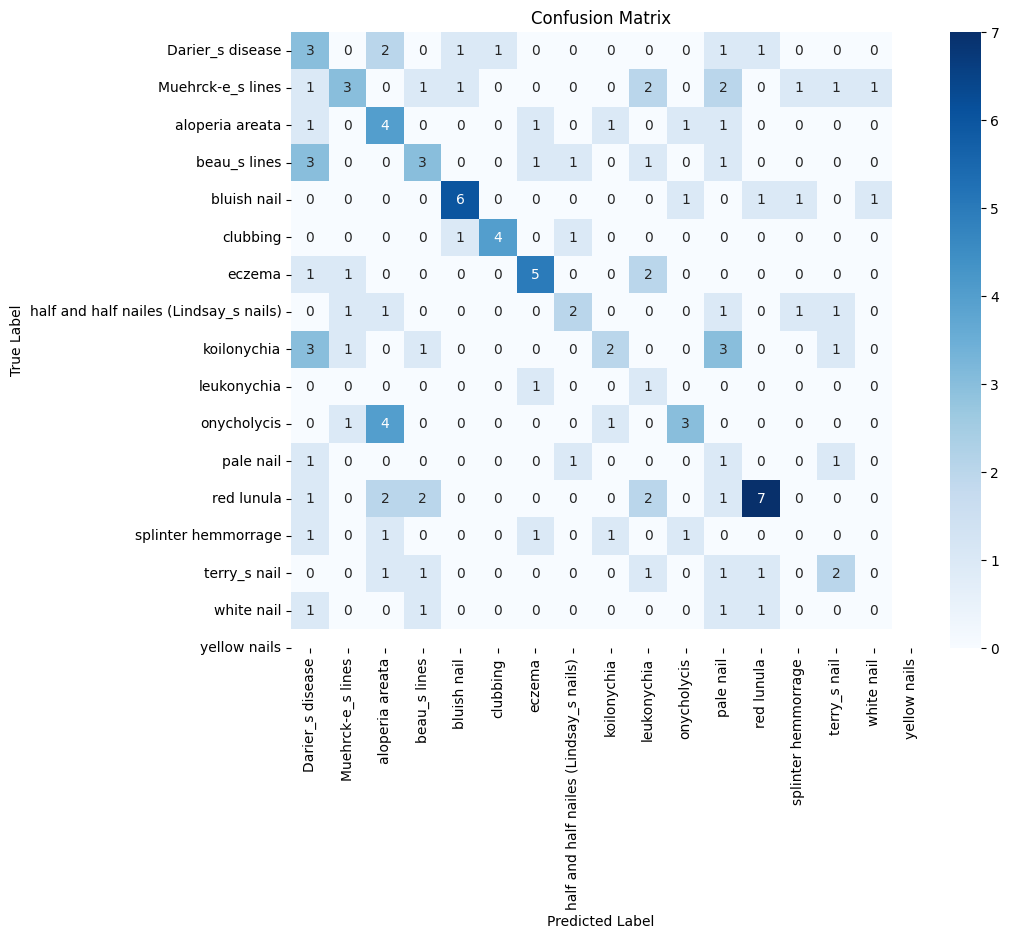

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [19]:
true_label_idx = class_names.index(predicted_label)

print(f"True label: {class_names[true_label_idx]}, Predicted label: {predicted_label}")
print(f"Confusion Matrix Value: {conf_matrix[true_label_idx, class_names.index(predicted_label)]}")

True label: bluish nail, Predicted label: bluish nail
Confusion Matrix Value: 6
